In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline

# 下載 NLTK 的停用詞
nltk.download('stopwords')
from nltk.corpus import stopwords

# 載入數據集
from datasets import load_dataset

# 載入數據集
ds = load_dataset("Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data")
df = pd.DataFrame(ds['train'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# 1. 處理缺失值和重複值
# 刪除缺失值
df.dropna(inplace=True)
# 刪除重複值
df.drop_duplicates(inplace=True)

In [7]:
# 2. 刪除 sentiment 中單字的出現頻率前 5% 和後 1%
# 計算單字頻率
all_comments = ' '.join(df['comment'])
words = re.findall(r'\w+', all_comments.lower())
word_counts = Counter(words)

In [8]:
# 計算要刪除的單字數量
num_words = len(word_counts)
threshold_high = int(num_words * 0.05)  # 前 5%
threshold_low = int(num_words * 0.01)    # 後 1%

In [9]:
# 獲取要刪除的單字
most_common_words = [word for word, count in word_counts.most_common(threshold_high)]
least_common_words = [word for word, count in word_counts.most_common()[:-threshold_low-1:-1]]


In [10]:
# 刪除不常見和常見的單字
words_to_remove = set(most_common_words + least_common_words)
df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))

In [15]:
# 3. 隨機抓取 50 個單字進行分析
# 生成一個新的 DataFrame 包含剩餘的單字
all_comments_after_removal = ' '.join(df['comment'])
remaining_words = re.findall(r'\w+', all_comments_after_removal)
remaining_word_counts = Counter(remaining_words)

# 隨機抽取 50 個單字
sampled_words = pd.Series(remaining_word_counts).sample(n=50, random_state=42)

In [16]:
# 4. 繪製長條圖
# 將單字和其出現次數放入 DataFrame
sampled_df = pd.DataFrame(sampled_words).reset_index()
sampled_df.columns = ['word', 'count']


In [17]:
# 排序
sampled_df = sampled_df.sort_values(by='count', ascending=False)


C:\Users\USER\AppData\Local\Temp\ipykernel_21976\1290508852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sampled_df, x='word', y='count', palette='viridis')


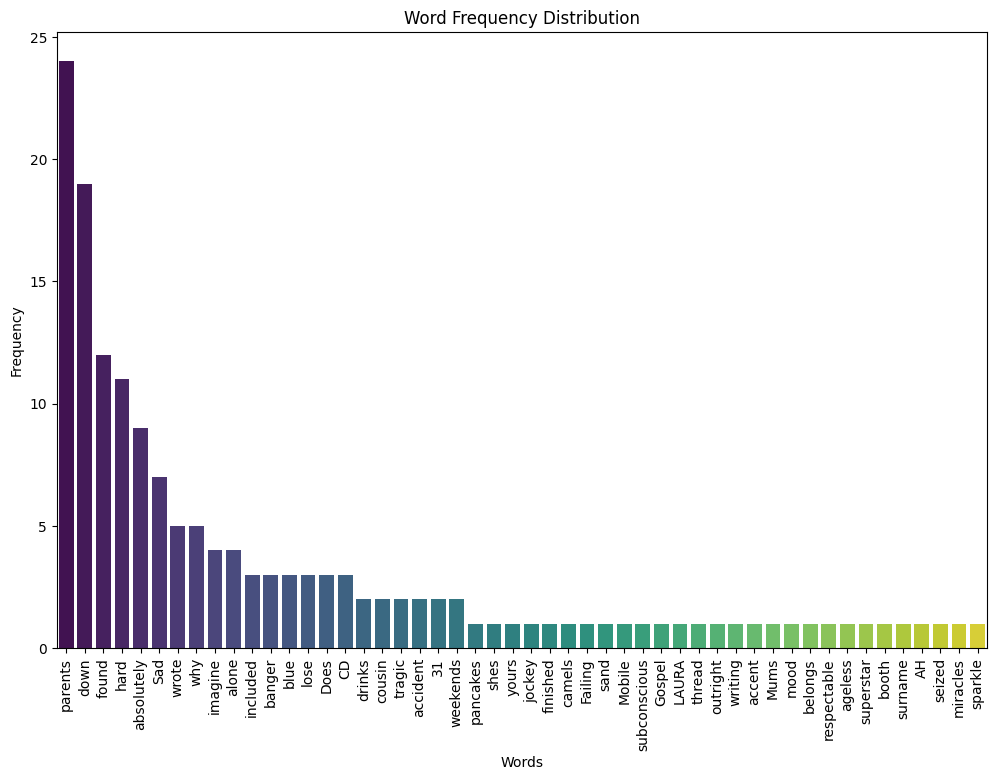

In [18]:
# 繪圖
plt.figure(figsize=(12, 8))
sns.barplot(data=sampled_df, x='word', y='count', palette='viridis')
plt.xticks(rotation=90)
plt.title('Word Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [21]:
# 4. 生成 TF-IDF 特徵
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['comment'])
y = df['sentiment']  # 目標變數

# 將資料集分割為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# 5. 實現 Naive Bayes 分類器（使用 TF-IDF 特徵）
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train, y_train)

# 預測和評估
y_pred_tfidf = nb_tfidf.predict(X_test)
print("Naive Bayes with TF-IDF:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Naive Bayes with TF-IDF:
Accuracy: 0.8333333333333334
               precision    recall  f1-score   support

    nostalgia       0.77      0.96      0.85       152
not nostalgia       0.95      0.70      0.81       148

     accuracy                           0.83       300
    macro avg       0.86      0.83      0.83       300
 weighted avg       0.86      0.83      0.83       300



In [25]:
# 6. 實現詞頻特徵的 Naive Bayes 分類器
# 生成詞頻特徵
count_vectorizer = CountVectorizer()
X_freq = count_vectorizer.fit_transform(df['comment'])

# 將資料集分割為訓練集和測試集
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=0.2, random_state=42)

# 實現 Naive Bayes 分類器（使用詞頻特徵）
nb_freq = MultinomialNB()
nb_freq.fit(X_train_freq, y_train_freq)

MultinomialNB()

In [26]:
# 預測和評估
y_pred_freq = nb_freq.predict(X_test_freq)
print("Naive Bayes with Word Frequency:")
print("Accuracy:", accuracy_score(y_test_freq, y_pred_freq))
print(classification_report(y_test_freq, y_pred_freq))

Naive Bayes with Word Frequency:
Accuracy: 0.8333333333333334
               precision    recall  f1-score   support

    nostalgia       0.77      0.95      0.85       152
not nostalgia       0.93      0.72      0.81       148

     accuracy                           0.83       300
    macro avg       0.85      0.83      0.83       300
 weighted avg       0.85      0.83      0.83       300



In [ ]:
#Multinomial Naive Bayes：適合處理多類別問題。它假設特徵的分佈是多項式分佈，這對於詞頻特徵效果很好。然而，當使用 TF-IDF 特徵時，因為這些特徵更像是概率分佈而不是計數，可能會導致不太理想的結果。

#Bernoulli Naive Bayes：這是一個適合二元特徵的分類器，對於 TF-IDF 特徵可能會有更好的效果，因為它假設特徵的存在或不存在是關鍵的，並且與文本的存在性有關

In [1]:
#############################################################################################

In [ ]:
#This is what I Change

In [ ]:
3. Data Transformation¶

In [ ]:
#因為可以用pandas讀取資料集，所以我直接從3開始
import pandas as pd

df = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

categories = ['not nostalgia','nostalgia']

X = pd.DataFrame(df, columns=['comment'])
X = X.rename(columns={'comment':'text'})

In [ ]:
len(X)

In [ ]:
X[0:2]

In [ ]:
# add category to the dataframe
#nostalgia = 1, not nostalgia = 0
X['category'] = df['sentiment'].apply(lambda x: 1 if x == 'nostalgia' else 0)

In [ ]:
# add category label also
X['category_name'] = df['sentiment']

In [ ]:
X[0:10]

In [ ]:
# a simple query
X[:10][["text","category_name"]]

In [ ]:
X[-10:]

In [ ]:
# using loc (by label)
X.loc[:10, 'text']

In [ ]:
# using iloc (by position)
X.iloc[:10, 0]

In [ ]:
### **>>> Exercise 2 (take home):** 

In [ ]:
#Answer here
print(X.loc[15:20, 'category_name'])
print(X.iloc[15:20, 2])

print(X[X.category==1][:10][["text","category_name"]])

In [ ]:
>>> Exercise 3

In [ ]:
# Answer here
# 沒有SCI 所以我用 not nostalgia
print(X[X.category_name=='not nostalgia'][::10][:5])

In [ ]:
4. Data Mining using Panda

In [ ]:
# check missing values
X.isnull()

In [ ]:
#我沒有import helper的function，我這邊用一個差不多的方法
def count_missing_values(df):
    return df.isnull().sum()

X.apply(lambda x: count_missing_values(x))

In [ ]:
>>> Exercise 4

In [ ]:
# Answer here

X.apply(lambda x: count_missing_values(x), axis=1)

In [ ]:
dummy_series = pd.Series(["dummy_record", 1], index=["text", "category"])

In [ ]:
dummy_series

In [ ]:
dummy_series.to_frame().T
# .to_frame() -> Convert Series to DataFrame
# .T          -> Transpose

In [ ]:
result_with_series = pd.concat([X, dummy_series.to_frame().T], ignore_index=True)

In [ ]:
# check if the records was commited into result
len(result_with_series)

In [ ]:
result_with_series.apply(lambda x: count_missing_values(x))

In [ ]:
# dummy record as dictionary format
dummy_dict = [{'text': 'dummy_record',
               'category': 1
              }]

In [ ]:
X = pd.concat([X, pd.DataFrame(dummy_dict)], ignore_index=True)

In [ ]:
len(X)

In [ ]:
X.apply(lambda x: count_missing_values(x))

In [ ]:
X.dropna(inplace=True)

In [ ]:
X.apply(lambda x: count_missing_values(x))

In [ ]:
len(X)

In [ ]:
### >>> **Exercise 5 

In [ ]:
import numpy as np

NA_dict = [{ 'id': 'A', 'missing_example': np.nan },
           { 'id': 'B'                    },
           { 'id': 'C', 'missing_example': 'NaN'  },
           { 'id': 'D', 'missing_example': 'None' },
           { 'id': 'E', 'missing_example':  None  },
           { 'id': 'F', 'missing_example': ''     }]

NA_df = pd.DataFrame(NA_dict, columns = ['id','missing_example'])
NA_df

In [ ]:
NA_df['missing_example'].isnull()

In [ ]:
# Answer here
# 從pandas官方的定義來看

# Return a boolean same-sized object indicating if the values are NA. NA values, such as None or numpy.NaN, 
# gets mapped to True values. Everything else gets mapped to False values. Characters such as empty strings '' or numpy.inf are not considered NA values 
# (unless you set pandas.options.mode.use_inf_as_na = True).

#所以只有np.nan,與None 是True，也就是0,1,4
#而其他都不被視為NA，包含字串，即使是空字串''

In [ ]:
X.duplicated()

In [ ]:
sum(X.duplicated())

In [ ]:
sum(X.duplicated('text'))

In [ ]:
dummy_duplicate_dict = [{
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        },
                        {
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        }]

In [ ]:
X = pd.concat([X, pd.DataFrame(dummy_duplicate_dict)], ignore_index=True)

In [ ]:
len(X)

In [ ]:
sum(X.duplicated())

In [ ]:
X.drop_duplicates(keep=False, inplace=True) # inplace applies changes directly on our dataframe

In [ ]:
len(X)

In [ ]:
5. Data Preprocessing

In [ ]:
X_sample = X.sample(n=1000) #random state

In [ ]:
len(X_sample)

In [ ]:
X_sample[0:4]

In [ ]:
>>> Exercise 6

In [ ]:
# Answer here
print(X[0:10])
print(X_sample[0:10])

#在 X_sample = X.sample(n=1000) 時，因為是隨機取樣，所以X_sample的index是不連續的且順序隨機的

print(X[X.index==941][['text']])
print(X_sample[X_sample.index==941][['text']])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
categories

In [ ]:
print(X.category_name.value_counts())

# plot barchart for X
X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 800],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

In [ ]:
print(X_sample.category_name.value_counts())

# plot barchart for X_sample
X_sample.category_name.value_counts().plot(kind = 'bar',
                                           title = 'Category distribution',
                                           ylim = [0, 600], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

In [ ]:
>>> Exercise 7

In [ ]:
# Answer here
# 方法一，只要不指定ylim，matplotlib就會自動調整y軸的範圍
plt.figure(figsize=(16,3))
plt.subplot(121)

X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution 1',
                                            
                                    rot = 0, fontsize = 11)


# 方法二，通過max()來決定y軸的範圍

plt.subplot(122)
#*1.1讓圖形更好看，不要太貼近上方
max_category = 1.1*X.category_name.value_counts().max()
X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution 2',
                                    ylim = [0, max_category],        
                                    rot = 0, fontsize = 11)

In [ ]:
>>> Exercise 8 

In [ ]:
# Answer here
bar1 = X.category_name.value_counts()
bar2 = X_sample.category_name.value_counts()
x = np.array(range(len(bar1)))

plt.figure(figsize=(6,4))
plt.bar(x-0.1, bar1, width=0.2, color='b', label='X',align='center')
plt.bar(x, bar2, width=0.2, color='y', label='X_sample',align='edge')
plt.xticks(x, bar1.index)
plt.xlabel('Category')
plt.ylabel('Samples')
plt.legend()
plt.show()